# CIR Model to simulate changes in Interest Rates and Liability Hedging

small change interest change

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import os,sys,inspect

current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)
import edhec_risk_kit as erk

import ipywidgets as widgets
from IPython.display import display

In [5]:
def inst_to_ann(r):
    """
    Converts short rate to an annualized rate
    """
    return np.expm1(r)

def ann_to_inst(r):
    """
    Converts annualized to a short rate
    """
    return np.log1p(r)

In [6]:
def cir(n_years=10, n_scenarios=1, a=0.05, b=0.03, sigma=0.05, steps_per_year=12, r_0=None):
    """
    Implements the CIR model for interest rates
    """
    if r_0 is None:
        r_0 = b
    r_0 = ann_to_inst(r_0)
    dt = 1 / steps_per_year

    num_steps = int(n_years * steps_per_year)
    shock = np.random.normal(0, scale=np.sqrt(dt), size=(num_steps, n_scenarios))
    rates = np.empty_like(shock)
    rates[0] = r_0

    for step in range(1, num_steps):
        r_t = rates[step-1]
        d_r_t = a * (b - r_t) * dt + sigma * np.sqrt(r_t) * shock[step]
        rates[step] = abs(r_t + d_r_t)

    return pd.DataFrame(data=inst_to_ann(rates), index=range(num_steps))

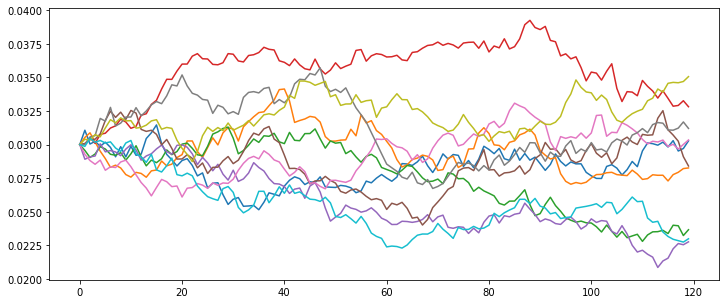

In [9]:
cir(n_scenarios=10, sigma=0.01).plot(figsize=(12, 5), legend=False)

In [10]:
def show_cir(r_0=0.03, a=0.5, b=0.03, sigma=0.05, n_scenarios=5):
    cir(r_0=r_0, a=a, b=b, sigma=sigma, n_scenarios=n_scenarios).plot(legend=False, figsize=(12,5))

import ipywidgets as widgets
from IPython.display import display
    
controls = widgets.interactive(show_cir,
                              r_0 = (0, .15, .01),
                              a = (0, 1, .1),
                               b = (0, .15, .01),
                               sigma= (0, .1, .01),
                               n_scenarios = (1, 100))
display(controls)

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.5, …

In [13]:
import math
def cir(n_years = 10, n_scenarios=1, a=0.05, b=0.03, sigma=0.05, steps_per_year=12, r_0=None):
    """
    Generate random interest rate evolution over time using the CIR model
    b and r_0 are assumed to be the annualized rates, not the short rate
    and the returned values are the annualized rates as well
    """
    if r_0 is None: r_0 = b 
    r_0 = ann_to_inst(r_0)
    dt = 1/steps_per_year
    num_steps = int(n_years*steps_per_year) + 1 # because n_years might be a float
    
    shock = np.random.normal(0, scale=np.sqrt(dt), size=(num_steps, n_scenarios))
    rates = np.empty_like(shock)
    rates[0] = r_0

    ## For Price Generation
    h = math.sqrt(a**2 + 2*sigma**2)
    prices = np.empty_like(shock)
    ####

    def price(ttm, r):
        _A = ((2*h*math.exp((h+a)*ttm/2))/(2*h+(h+a)*(math.exp(h*ttm)-1)))**(2*a*b/sigma**2)
        _B = (2*(math.exp(h*ttm)-1))/(2*h + (h+a)*(math.exp(h*ttm)-1))
        _P = _A*np.exp(-_B*r)
        return _P
    prices[0] = price(n_years, r_0)
    ####
    
    for step in range(1, num_steps):
        r_t = rates[step-1]
        d_r_t = a*(b-r_t)*dt + sigma*np.sqrt(r_t)*shock[step]
        rates[step] = abs(r_t + d_r_t)
        # generate prices at time t as well ...
        prices[step] = price(n_years-step*dt, rates[step])

    rates = pd.DataFrame(data=inst_to_ann(rates), index=range(num_steps))
    ### for prices
    prices = pd.DataFrame(data=prices, index=range(num_steps))
    ###
    return rates, prices


In [15]:
def show_cir_prices(r_0=0.03, a=0.5, b=0.03, sigma=0.05, n_scenarios=5):
    prices = cir(r_0=r_0, a=a, b=b, sigma=sigma, n_scenarios=n_scenarios)[1]
    prices.plot(legend=False, figsize=(12,5))

import ipywidgets as widgets
from IPython.display import display
    
controls = widgets.interactive(show_cir_prices,
                              r_0 = (0, .15, .01),
                              a = (0, 1, .1),
                               b = (0, .15, .01),
                               sigma= (0, .1, .01),
                               n_scenarios = (1, 100))
display(controls)

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.5, …

In [26]:
a_0 = .75
rates, bond_prices = cir(n_years=10, r_0=0.03, b=0.03, n_scenarios=10)
liabilities = bond_prices
zcbond_10 = pd.Series(data=[1], index=[10])
zc_0 = erk.pv(zcbond_10, r=0.03)
n_bonds = a_0/zc_0
asset_value_zc_bonds = n_bonds * bond_prices

asset_value_cash = a_0 * (rates/12+1).cumprod()

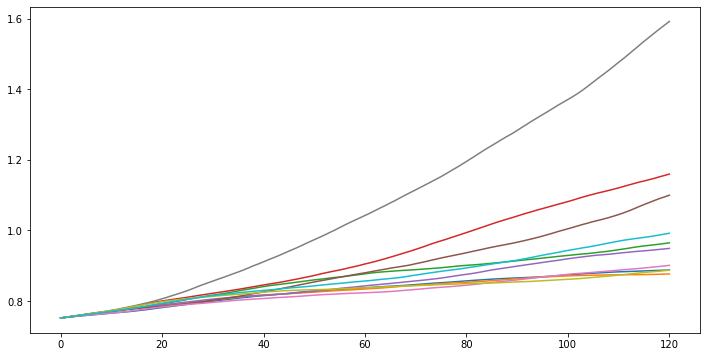

In [27]:
asset_value_cash.plot(legend=False, figsize=(12, 6))

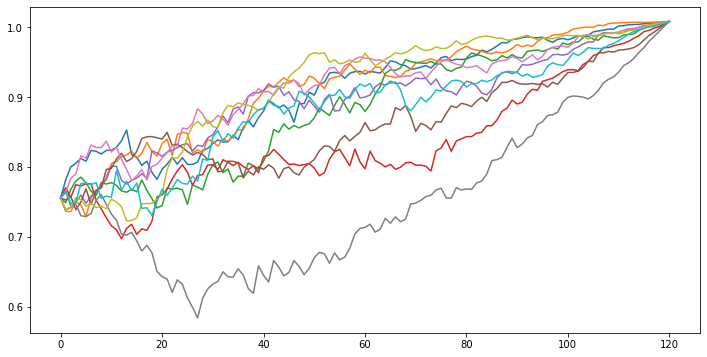

In [28]:
asset_value_zc_bonds.plot(legend=False, figsize=(12, 6))

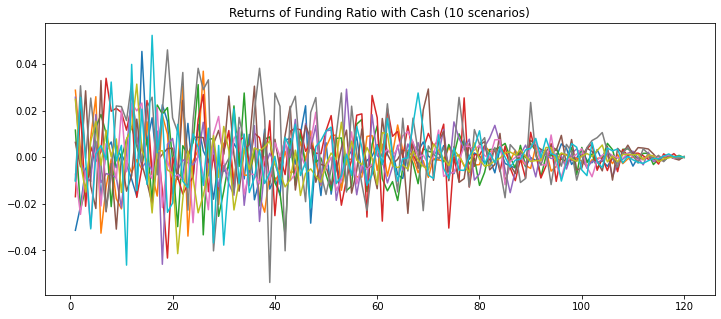

In [29]:
(asset_value_cash/liabilities).pct_change().plot(title='Returns of Funding Ratio with Cash (10 scenarios)', legend=False, figsize=(12,5))

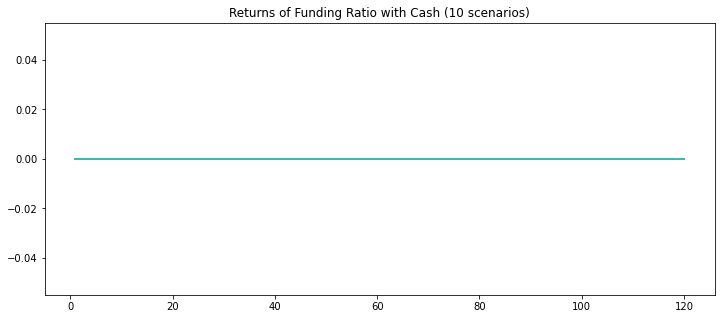

In [30]:
(asset_value_zc_bonds/liabilities).pct_change().plot(title='Returns of Funding Ratio with Cash (10 scenarios)', legend=False, figsize=(12,5))

In [31]:
a_0 = 0.75
rates, bond_prices = cir(n_scenarios=10000, r_0=0.03, b=0.03)
liabilities = bond_prices
zc_0 = erk.pv(zcbond_10, 0.03)
n_bonds = a_0/zc_0
asset_value_zc_bonds = n_bonds * bond_prices
asset_value_cash = a_0 * (rates/12+1).cumprod()

In [ ]:
tfr_cash = asset_value_cash.iloc[-1]/liabilities.iloc[-1]
tfr_zc_bonds = asset_value_zc_bonds.iloc[-1]/liabilities.iloc[-1]
tfr_cash.plot.hist(label="Cash", figsize=(15,6), bins=100)